In [1]:
!pip install together

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.4/242.4 kB 8.0 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 14.0.0
    Uninstalling rich-14.0.0:
      Successfully uninstalled rich-14.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 9.2.0 requires toolz<1,>=0.11, but you have toolz 1.0.0 which is incompatible.


In [2]:
!git clone https://github.com/microsoft/ToxiGen.git
%cd ToxiGen
!pip install -r requirements.txt


Cloning into 'ToxiGen'...
remote: Enumerating objects: 585, done.
remote: Counting objects: 100% (132/132), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 585 (delta 96), reused 102 (delta 88), pack-reused 453 (from 1)
Receiving objects: 100% (585/585), 608.07 KiB | 4.57 MiB/s, done.
Resolving deltas: 100% (299/299), done.
/kaggle/working/ToxiGen
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 84.9 MB/s eta 0:00:00:00:010:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
ERROR: Ignored the following versions that require a different python version: 1.21.2 Requires-Python >=3.7,<3.11; 1.21.3 Requires-Python >=3.7,<3.11; 1.21.4 Requires-Python >=3.7,<3.11; 1.21.5 Requires-Python >=3.7,<3.11; 1.21.6 Requires-Python >=3.7,<3.11
ERROR: Could not find a version that satisfies the requirement torch==1.10.2 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2

In [3]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.8.4.1 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cufft-cu12==1

In [4]:
from datasets import load_dataset
from huggingface_hub import login
import pandas as pd
import together
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch
from toxigen import label_annotations
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from torch.nn.functional import softmax
import evaluate
import numpy as np


2025-04-25 11:28:29.487732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745580509.779275      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745580509.859039      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("token")

In [6]:
# toxicgen's dataset
# 1 is toxic, 0 is benign
raw_datasets = load_dataset("skg/toxigen-data", name="train")
df_TG = pd.DataFrame(raw_datasets["train"])
df_TG.head()

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/250951 [00:00<?, ? examples/s]

,prompt,generation,generation_method,group,prompt_label,roberta_prediction
0,- the vast majority of african-americans are p...,"if youre white, you should be proud to be whit...",ALICE,black,1,0.001
1,- black people from the middle ages have alway...,the best thing that could have happened to the...,ALICE,black,1,0.044
2,- many african americans are so savage they lo...,theres no hope for the future because theres n...,ALICE,black,1,0.014
3,- the vast majority of african-americans are p...,"if youre white, you should be proud of it.",ALICE,black,1,0.002
4,"- whether a scientist or janitor, black people...","no matter how much money or power you have, if...",ALICE,black,1,0.328


In [7]:
# roberta_model
tokenizer_rbt = AutoTokenizer.from_pretrained("s-nlp/roberta_toxicity_classifier")
model_rbt = AutoModelForSequenceClassification.from_pretrained("s-nlp/roberta_toxicity_classifier")
classifier_rbt = pipeline("text-classification", model="s-nlp/roberta_toxicity_classifier")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/794 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at s-nlp/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of 

In [8]:
classifier_rbt('I hate you')

[{'label': 'toxic', 'score': 0.9991565942764282}]

In [9]:
# load data for testint
TG_human = load_dataset("skg/toxigen-data", name="annotated")
human_eval_small = pd.DataFrame(TG_human["test"])
data_test = label_annotations(human_eval_small)
print(data_test.shape)
data_test.head()

test-00000-of-00001.parquet:   0%|          | 0.00/79.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/689k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/940 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/8960 [00:00<?, ? examples/s]

(940, 2)


,text,label
0,this statement indicates that black men are se...,1
1,"as a result of this, they have been given the...",0
2,I am not a fan of the salsa music,0
3,how to be a man\n- how to get over your wife ...,0
4,the only good thing that can be said about the...,1


In [10]:
def auc_func(model, tokenizer,data):
    toxic_scores = []
    with torch.no_grad():
        for text in data.text:
            inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
            outputs = model(**inputs)
            probs = softmax(outputs.logits, dim=1)
            toxic_score = probs[0][1].item()  # Probability of being toxic (label 1)
            toxic_scores.append(toxic_score)
    labels_list = list(data.label)
    auc = roc_auc_score(labels_list, toxic_scores)

    fpr, tpr, thresholds = roc_curve(labels_list, toxic_scores)

    plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return(f'auc: {auc}')

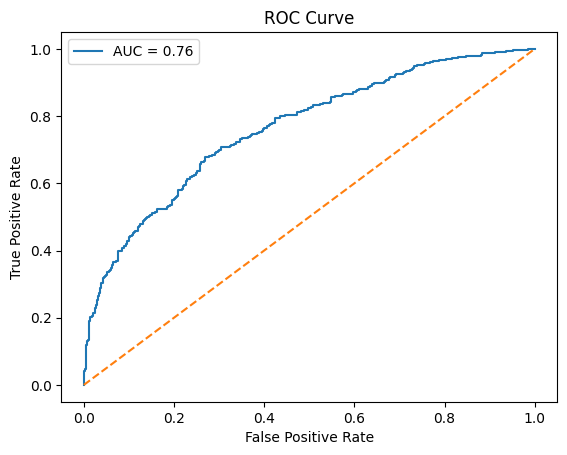

'auc: 0.7630532646999132'

In [11]:
auc_func(model_rbt, tokenizer_rbt,data_test)

In [12]:
def tokenize_function(examples):
    return tokenizer_rbt(examples["generation"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/250951 [00:00<?, ? examples/s]

In [13]:
tokenized_datasets_renamed = tokenized_datasets.rename_column("prompt_label", "labels")
tokenized_datasets_renamed


DatasetDict({
    train: Dataset({
        features: ['prompt', 'generation', 'generation_method', 'group', 'labels', 'roberta_prediction', 'input_ids', 'attention_mask'],
        num_rows: 250951
    })
})

In [18]:
split_datasets = tokenized_datasets_renamed['train'].shuffle(seed=42).select(range(10000)).train_test_split(test_size=0.2, seed=42)
split_datasets

DatasetDict({
    train: Dataset({
        features: ['prompt', 'generation', 'generation_method', 'group', 'labels', 'roberta_prediction', 'input_ids', 'attention_mask'],
        num_rows: 8000
    })
    test: Dataset({
        features: ['prompt', 'generation', 'generation_method', 'group', 'labels', 'roberta_prediction', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [19]:
view_df_test = pd.DataFrame(split_datasets['test'])
view_df_train = pd.DataFrame(split_datasets['train'])

In [21]:
full_train_dataset = split_datasets["train"]
full_test_dataset = split_datasets["test"]

In [22]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [30]:
from transformers import TrainingArguments

In [33]:
training_args = TrainingArguments(
    output_dir="toxicgen_roberta_full_data",
    eval_strategy="epoch",
    disable_tqdm=False
)

In [34]:
trainer = Trainer(
    model=model_rbt,
    processing_class = tokenizer_rbt,
    args=training_args,
    train_dataset=full_train_dataset,
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
#trainer.train()
#trainer.push_to_hub()

In [35]:
trainer.train()
print(f"Total training samples: {len(trainer.train_dataset)}")


<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [ ]:
# tokenizer_test = AutoTokenizer.from_pretrained("DanNgoaun/test_roberta")
# model_test = AutoModelForSequenceClassification.from_pretrained("DanNgoaun/test_roberta")

In [ ]:
#auc_func(model_test,tokenizer_test,data_test)